# Optimising Gd concentration, TE and TR for SNR efficiency

Use this tool to find the optimum TR and Gd concentration for a range of TE values.

Use the first two cells to define the range of TE, TR and Gd parameters that you want to model, and your relaxometry data at different concentrations of Gd, then run all cells to see the result. To run a cell, select it and type ctrl + enter. Run all cells to view the plot interactively.

**Reference:** Barrett, RLC, Cash, D, Simmons, C, et al. Tissue Optimisation Strategies for High Quality Ex Vivo Diffusion Imaging. NMR in Biomedicine. 2022;e4866. https://doi.org/10.1002/nbm.4866

## 1. Enter data and parameters
Edit the values for `te`, `tr`, `gd`, `gd_data`, `t1_data` and `t2_data` in the cells below. 

First enter the range values of TE, TR and Gd concentration that you want to model (min, max):

In [1]:
# TE and TR in ms 
te = (15, 25)
tr = (100, 300)

# Gd concentration in mM
gd = (0, 8)

Now enter your measurements of T1 and T2 at different concentrations of Gd:

In [2]:
# Concentration of contrast agent in mM
gd_data = [0, 4, 8]
# Corresponding values of T1 and T2 in ms
t1_data = [1000, 80, 50]
t2_data = [45, 21, 14]

## 2. Run SNR efficiency model
Run the cell below to get the optimum TR and Gd concentration for the range of TE values defined above.

*Note:* If needed you can change the precision by altering the parameters `gd_step_size`, `te_step_size`, and `tr_step_size` in the code below.

TE (ms),TR_best (ms),Gd_best (mM)
15,138,4.2
16,147,3.9
17,157,3.6
18,165,3.4
19,177,3.1
20,183,3.0
21,193,2.8
22,204,2.6
23,211,2.5
24,224,2.3


<IPython.core.display.Javascript object>


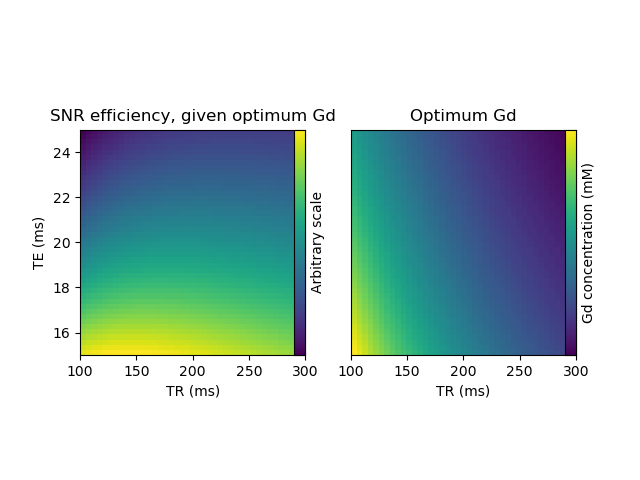

In [3]:
# Set up for interactive plots to work in Colab
try:
    from google.colab import output
    !conda install ipympl > /dev/null 2>&1
    output.enable_custom_widget_manager()
    %matplotlib ipympl
except:
    %matplotlib notebook

# Import python packages
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Set step size: This corresponds to precision in output, e.g. gd_step_size = 0.1 gives results to the 
# nearest 0.1 mM, te_step_size = 1 gives results for TE for each ms, etc.
gd_step_size = 0.1 
te_step_size = 1
tr_step_size = 1

### First let's fit gd_data, t1_data and t2_data to the relaxivity vs contrast agent concentration function

# Define relaxivity vs Gd concentration function
def fun(gd, r_0, r_i):
    return r_0 + gd*r_i

# Curve fit for T1 data
# Define xdata and ydata
xdata = gd_data
# Convert T1 to R1 values
ydata = 1/np.array(t1_data)

# Curve fit for R1 parameters
r1_params, pcov = curve_fit(fun, xdata, ydata)

# Curve fit for T2 data
# Define xdata and ydata
xdata = gd_data
# Convert T2 to R2 values
ydata = 1/np.array(t2_data)

# Curve fit for R2 parameters
r2_params, pcov = curve_fit(fun, xdata, ydata)

# Convert curve parameters from relaxivity back to T1 and T2
t1_params = 1/r1_params
t2_params = 1/r2_params

### Now let's use these parameters to estimate T1 and T2 for the range of Gd concentration(s), 
### TE and TR values given in gd, te, tr

# Rewrite relaxivity vs Gd concentration function in terms of T1 and T2
def fun_t(gd, t_0, t_i):
    return t_0 * t_i / (t_i + t_0 * gd)

# SNR efficiency function
def snreff_spin_echo(tr, te, t1, t2):
    '''SNR efficiency scaling factor for spin echo'''
    return (np.exp(-te / t2) * (1 - np.exp(-tr / t1) * (2 * np.exp(te / (2 * t1)) - 1))) / np.sqrt(tr)

# Get SNR efficiency function
def get_snreff(te_min, te_max, te_step, tr_min, tr_max, tr_step, gd_min, gd_max, gd_step):
    # Define Gd concentrations, TE and TR values
    gd_vals = np.arange(gd_min, gd_max + 1, gd_step)
    te_vals = np.arange(te_min, te_max + 1, te_step)
    tr_vals = np.arange(tr_min, tr_max + 1, tr_step)
    # Simulate T1 and T2 values based on Gd concentration
    t_0, t_i = t1_params
    t1_vals = fun_t(gd_vals, t_0, t_i)
    t_0, t_i = t2_params
    t2_vals = fun_t(gd_vals, t_0, t_i)
    # Calculate SNR efficiency
    snreff = np.zeros([len(te_vals), len(tr_vals), len(gd_vals)])
    for i, TE in enumerate(te_vals):
        for j, (T1, T2) in enumerate(zip(t1_vals, t2_vals)):
            snreff[i, :, j] = snreff_spin_echo(tr_vals, TE, T1, T2)
    # Find maximum SNR efficiency accross Gd values, and the Gd which gives max SNR
    snreff_best_gd = np.max(snreff, axis=2)
    best_gd_index = np.argmax(snreff, axis=2).flatten()
    best_gd = [gd_vals[i] for i in best_gd_index]
    best_gd = np.reshape(best_gd, snreff_best_gd.shape)
    # return outputs
    return snreff, snreff_best_gd, best_gd, gd_vals, te_vals, tr_vals

### First, let's calculate SNR efficiency for results table, using given step size for precision
snreff, snreff_best_gd, best_gd, gd_vals, te_vals, tr_vals = get_snreff(*te, te_step_size, 
                                                                        *tr, tr_step_size, 
                                                                        *gd, gd_step_size)

# Put results in a table
df = pd.DataFrame(columns=['TE (ms)', 'TR_best (ms)', 'Gd_best (mM)'])
df['TE (ms)'] = te_vals
for i in df.index:
    j = np.argmax(snreff_best_gd[i,:])
    df.loc[i,'TR_best (ms)']= tr_vals[j]
    df.loc[i,'Gd_best (mM)']= best_gd[i,j]

# Print a nice table with heading
display(HTML('<h3>Optimal TR and Gd concentrations for given TE values</h3>'))
display(HTML(df.to_html(index=False)))
print('\n')

### Second, let's calculate SNR efficiency again for the figure, with step size fixed at high precision to
# make it look nice.
snreff, snreff_best_gd, best_gd, gd_vals, te_vals, tr_vals = get_snreff(*te, (te[1] - te[0])/40,
                                                                        *tr, (tr[1] - tr[0])/40,
                                                                        *gd, (gd[1] - gd[0])/400)
# Make a figure heading
display(HTML('<h3>SNR efficiency and Optimum Gd for given values of TE and TR</h3>'))
# Create the figure
fig = plt.figure(facecolor='white')

# Create gridspec structure
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Set aspect ratio for subplots
aspect = (tr[1]-tr[0])/(te[1]-te[0])

# Do the SNR efficiency subplot
ax1 = plt.subplot(gs[0,0])
im1 = ax1.imshow(snreff_best_gd, origin='lower', extent=[*tr, *te], aspect=aspect)
ax1.set_title('SNR efficiency, given optimum Gd')
ax1.set_xlabel('TR (ms)')
ax1.set_ylabel('TE (ms)')

# Add colourbar
axins = inset_axes(ax1, width='5%', height='100%', borderpad=0)
cb = fig.colorbar(im1, cax=axins, ticks=[], label='Arbitrary scale')

# Do the Optimum Gd subplot
ax2 = plt.subplot(gs[0,1])
im2 = ax2.imshow(best_gd, origin='lower', extent=[*tr, *te], aspect=aspect)
ax2.set_title('Optimum Gd')
ax2.set_xlabel('TR (ms)')
ax2.set_yticks([])

# Add colourbar
axins = inset_axes(ax2, width='5%', height='100%', borderpad=0)
cb = fig.colorbar(im2, cax=axins, ticks=[], label='Gd concentration (mM)')

plt.show()